# *TP1 - DEEP LEARNING*

<table style="width:100%">
  <tr>
    <td style="text-align:left"><strong>Préparé par :</strong> EL Warraqi Imane</td>
    <td style="text-align:right"><strong>Encadré par :</strong> Pr. HAMZA EL KHALFI </td>
  </tr>
</table>

# Partie 2 : _Implémentation avec Pytorch_


### 2.4 Simplification de SGD avec `torch.optim`

In [1]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt

**Chargement des données : CirclesData**



In [2]:
# charger les utilitaires de générations et visualisation des données
from utilitaires import *

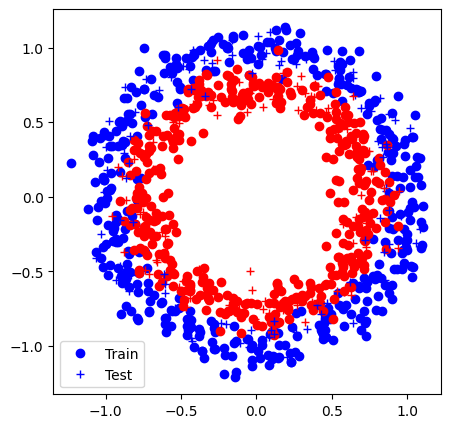

In [3]:
# charger / préparer / visualiser les données pour apprentissage
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
plot_data(data)

##### **Mise à jour de la fonciton `init_model` qui déclare l'architecture du modèle, la loss et l'optimiseur.**

In [4]:
def init_model(nx, nh, ny,eta):
    
   # model = None
    #loss = None
    
    #####################
    ## Votre code ici  ##
    #####################
    model = nn.Sequential(
        nn.Linear(nx, nh),  # couche cachée
        nn.Tanh(),          # activation tanh
        nn.Linear(nh, ny)   # couche de sortie
        # pas de SoftMax ici si on utilise CrossEntropyLoss
    )
    optim = torch.optim.SGD(model.parameters(), lr=eta)
    loss = torch.nn.CrossEntropyLoss()
    return model, loss, optim

La fonction `loss_accuracy` reste inchangée mais la fonction `sgd` est supprimée. À la place, on fera un appel à `optim.zero_grad()` avant de faire le backward et à `optim.step()` après le backward.

In [5]:
def loss_accuracy(loss, Yhat, Y):
    """
        Calcul de la loss et de l'accuracy.

        - loss : fonction de loss (ex: nn.CrossEntropyLoss)
        - Yhat    : sortie du modèle (logits)  -> shape [batch_size, n_classes]
        - Y       : labels réels (indices)   -> shape [batch_size]

        Returns:
        - L       : valeur scalaire de la loss
        - acc     : précision (taux de bonnes prédictions)
        """

    L = loss(Yhat, Y)
    preds = torch.argmax(Yhat, dim=1)
    acc = (preds == Y).float().mean().item()
    #####################
    ## Votre code ici  ##
    #####################
    # faire appel à la fonction de loss

    return L, acc

##### **Mise à jour de l'algorithme global (avec autograd, les couches `torch.nn` et `torch.optim`)**

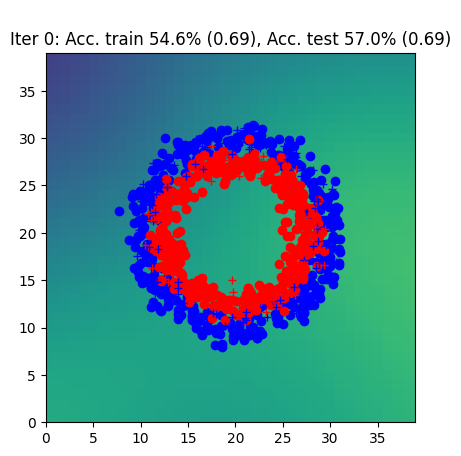

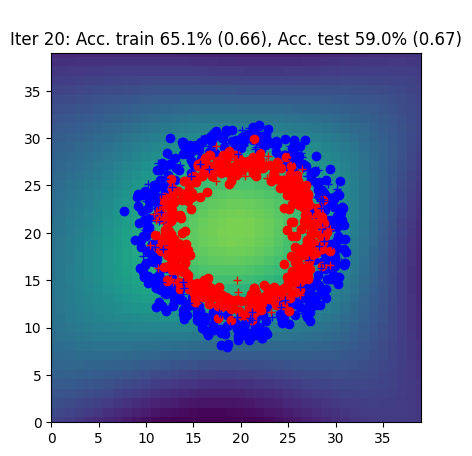

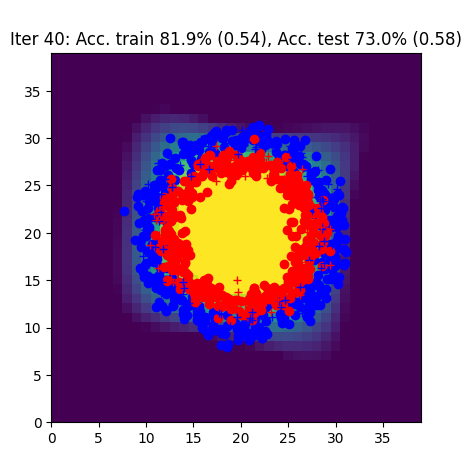

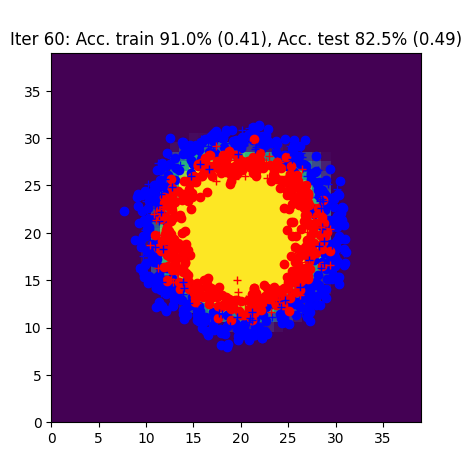

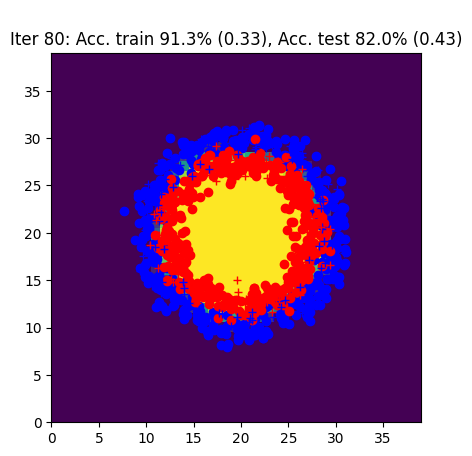

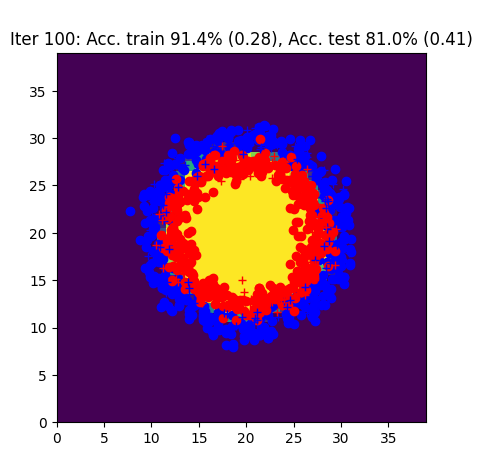

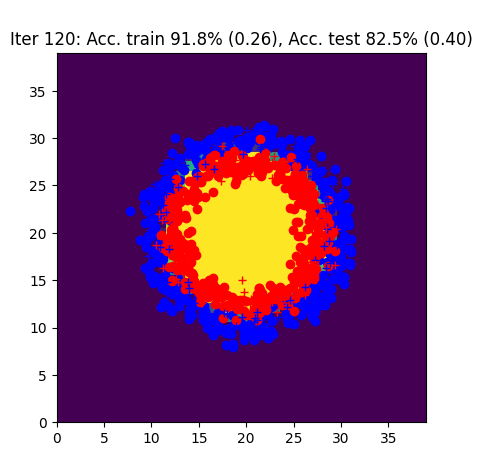

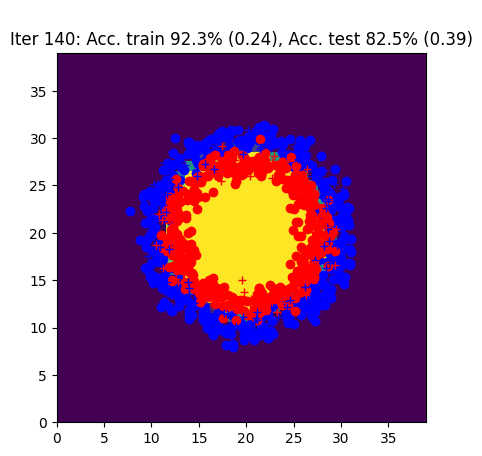

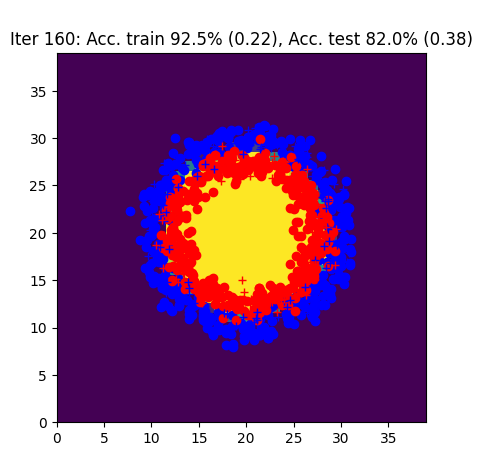

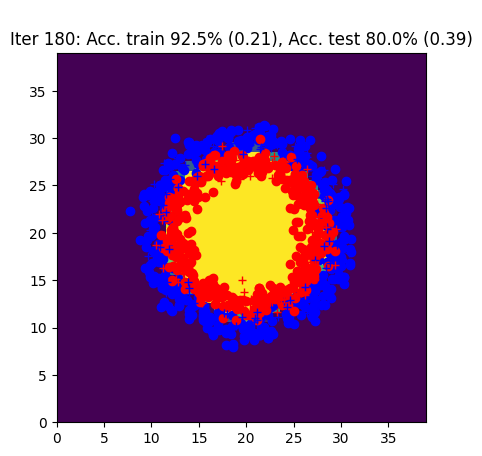

In [7]:
# initialisation des params
eta = 0.03
model, loss_fn , optim = init_model(nx, nh, ny,eta)

# epoch
curves = [[], [], [], [], [], []]
for iteration in range(200):

    # permutations
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # initialisation loss et acc par batch
    Loss = []
    Acc = []

    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        #####################
        ## Forward pass ##
        #####################
        Yhat = model(X)  # sortie du réseau

        #####################
        ## Calcul de la loss et accuracy ##
        #####################
        # Attention CrossEntropyLoss attend Y comme indices de classes, pas one-hot
        # Si Y est one-hot, faire torch.argmax
        if Y.ndim > 1 and Y.shape[1] > 1:
            Y_labels = torch.argmax(Y, dim=1)
        else:
            Y_labels = Y

        loss = loss_fn(Yhat, Y_labels)
        # accuracy
        preds = torch.argmax(Yhat, dim=1)
        acc = (preds == Y_labels).float().mean().item()

        Loss.append(loss.item())
        Acc.append(acc)

        #####################
        ## Backward ##
        #####################
        optim.zero_grad()
        loss.backward()
        optim.step()

    # accumulation de la loss et des accuracy par batch
    LBatch = np.mean(Loss)
    accBatch = np.mean(Acc)

    # évaluation sur tout le dataset
    Yhat_train = model(data.Xtrain)
    if data.Ytrain.ndim > 1 and data.Ytrain.shape[1] > 1:
        Ytrain_labels = torch.argmax(data.Ytrain, dim=1)
    else:
        Ytrain_labels = data.Ytrain
    Ltrain = loss_fn(Yhat_train, Ytrain_labels).item()
    acctrain = (torch.argmax(Yhat_train, dim=1) == Ytrain_labels).float().mean().item() * 100

    Yhat_test = model(data.Xtest)
    if data.Ytest.ndim > 1 and data.Ytest.shape[1] > 1:
        Ytest_labels = torch.argmax(data.Ytest, dim=1)
    else:
        Ytest_labels = data.Ytest
    Ltest = loss_fn(Yhat_test, Ytest_labels).item()
    acctest = (torch.argmax(Yhat_test, dim=1) == Ytest_labels).float().mean().item() * 100

    # Affichage périodique
    if iteration % 20 == 0:
        title = f'\nIter {iteration}: Acc. train {acctrain:.1f}% ({Ltrain:.2f}), Acc. test {acctest:.1f}% ({Ltest:.2f})'
        Ygrid = model(data.Xgrid)
        plot_data_with_grid(data, torch.nn.Softmax(dim=1)(Ygrid).detach().numpy(), title)

    # Sauvegarde des métriques
    curves[0].append(accBatch)
    curves[1].append(acctrain)
    curves[2].append(acctest)
    curves[3].append(LBatch)
    curves[4].append(Ltrain)
    curves[5].append(Ltest)


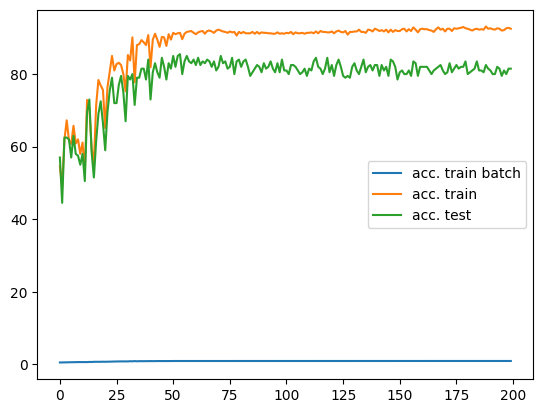

In [8]:
fig = plt.figure()
plt.plot(curves[0], label="acc. train batch")
plt.plot(curves[1], label="acc. train")
plt.plot(curves[2], label="acc. test")
plt.legend()
plt.show()

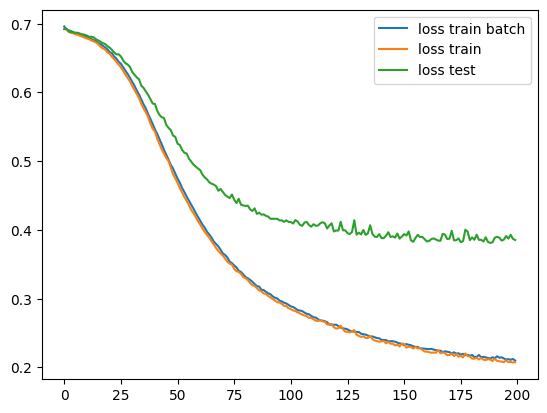

In [9]:
fig = plt.figure()
plt.plot(curves[3], label="loss train batch")
plt.plot(curves[4], label="loss train")
plt.plot(curves[5], label="loss test")

plt.legend()
plt.show()